# Analyze snowmodel results by elevation

5/19,16/2020. https://github.com/emiliom

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import s3fs
import pandas as pd
import xarray as xr

from snowmodelzarrfs import connect_fs, get_zarrstore

**TODO:** Use a local cluster during my R&D, and later on pangeo use a `dask_gateway`

In [2]:
dpth = Path('/usr/mayorgadat/workmain/aarendt/CSO/projectwork/snow_model')

## DEM

In [3]:
dem_da = xr.open_rasterio(dpth / 'DEM_WY_COG.tif')

In [4]:
dem_da

<xarray.DataArray (band: 1, y: 8254, x: 4605)>
[38009670 values with dtype=int16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.938e+06 4.938e+06 4.938e+06 ... 4.69e+06 4.69e+06
  * x        (x) float64 4.872e+05 4.872e+05 4.873e+05 ... 6.253e+05 6.253e+05
Attributes:
    transform:      (30.0, 0.0, 487200.0, 0.0, -30.0, 4937700.0)
    crs:            +init=epsg:32612
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('elevation',)
    AREA_OR_POINT:  Area

In [5]:
dem2d = dem_da.squeeze(drop=True)

In [6]:
dem2d.values.min(), dem2d.values.max(), dem2d.values.mean()

(1697, 4160, 2500.8653754426177)

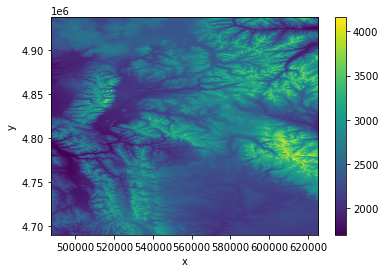

In [7]:
# Note: dem2d.plot() (pcolormesh) returns a blank plot
dem2d.plot.imshow()

Cell resolution

In [8]:
dem2d.x.values[10] - dem2d.x.values[9], dem2d.y.values[10] - dem2d.y.values[9]

(30.0, -30.0)

## Read snow_model output zarr-geo

In [9]:
# Options: localfs, localminio_s3, aws_s3, anon_aws_s3
fs_type, bucket = "localfs", "snowmodel"

Read from `snowmodel/swe_run_a-geo.zarr`, a zarr dataset optimized for whole-spatial-domain queries such as a map figure of a specific day (time step) or statistics calculated on the data from one time step.

**NOTE:** the `xr.open_zarr` statement below is pretty slow when accessing from S3. We'll need to look into it.

In [10]:
zarrgeo = "swe_run_a-geo.zarr"

In [11]:
zarrstore_geo = get_zarrstore('na', fs_type, bucket, zarrgeo, base_dpth=dpth)

In [12]:
zdsgeo = xr.open_zarr(
    store=zarrstore_geo, 
    consolidated=True
)

In [13]:
zdsgeo

,Array,Chunk
Bytes,24.98 GB,54.75 MB
Shape,"(1825, 2476, 1382)","(4, 2476, 1382)"
Count,458 Tasks,457 Chunks
Type,float32,numpy.ndarray


## combined analysis

### Create binned DEM (elevation classes)

First regrid/interpolate the DEM to the swe grid

In [14]:
dem_interp = dem2d.interp_like(zdsgeo.swe, method='linear')

In [15]:
dem_interp

<xarray.DataArray (y: 2476, x: 1382)>
array([[          nan, 2216.        , 2270.        , ..., 2112.69444444,
        2112.        , 2114.        ],
       [          nan, 2254.        , 2269.        , ..., 2112.        ,
        2114.        , 2116.        ],
       [          nan, 2300.        , 2286.        , ..., 2111.16666667,
        2114.        , 2115.        ],
       ...,
       [          nan, 2255.        , 2266.        , ..., 2329.58333333,
        2323.        , 2360.41666667],
       [          nan, 2252.66666667, 2262.        , ..., 2348.25      ,
        2332.25      , 2361.66666667],
       [          nan, 2251.55555556, 2267.5       , ..., 2351.55555556,
        2343.        , 2380.94444444]])
Coordinates:
  * y        (y) int64 4690100 4690200 4690300 ... 4937400 4937500 4937600
  * x        (x) int64 487200 487300 487400 487500 ... 625100 625200 625300
Attributes:
    transform:      (30.0, 0.0, 487200.0, 0.0, -30.0, 4937700.0)
    crs:            +init=epsg:32612
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    descriptions:   ('elevation',)
    AREA_OR_POINT:  Area

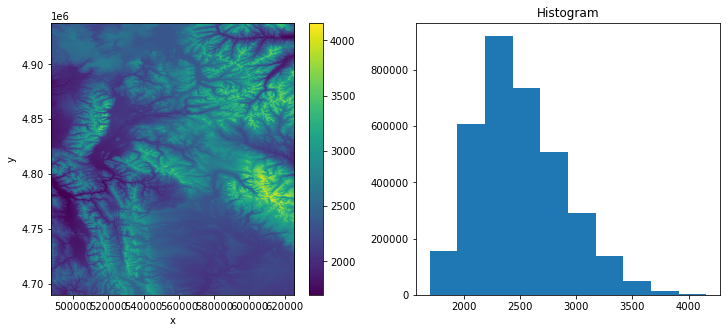

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
dem_interp.plot.imshow(ax=ax1)
dem_interp.plot.hist(ax=ax2);

Cell resolution

In [17]:
dem_interp.x.values[10] - dem_interp.x.values[9], dem_interp.y.values[10] - dem_interp.y.values[9]

(100, 100)

Create binned DEM based on multiple elevation bins. See [this](https://stackoverflow.com/questions/57419541/how-to-use-apply-ufunc-with-numpy-digitize-for-each-image-along-time-dimension-o), which relies on [numpy.digitize](https://numpy.org/doc/stable/reference/generated/numpy.digitize.html?highlight=digitize#numpy.digitize). Also explored using a simple two-class categorization with `xr.where`, but it was too limiting

In [18]:
rmin, rmax = 1500, 4500
bins = np.arange(rmin, rmax+1, 500)

In [19]:
bins

array([1500, 2000, 2500, 3000, 3500, 4000, 4500])

### Binning approach 1

In [20]:
bins1 = bins[:-1]

In [22]:
dembinned = xr.apply_ufunc(np.digitize, dem_interp, bins1)

# a name is needed for groupby b/c `apply_ufunc` does not create one
dembinned.name = 'dem_bins'

In [23]:
dembinned

<xarray.DataArray 'dem_bins' (y: 2476, x: 1382)>
array([[6, 2, 2, ..., 2, 2, 2],
       [6, 2, 2, ..., 2, 2, 2],
       [6, 2, 2, ..., 2, 2, 2],
       ...,
       [6, 2, 2, ..., 2, 2, 2],
       [6, 2, 2, ..., 2, 2, 2],
       [6, 2, 2, ..., 2, 2, 2]])
Coordinates:
  * y        (y) int64 4690100 4690200 4690300 ... 4937400 4937500 4937600
  * x        (x) int64 487200 487300 487400 487500 ... 625100 625200 625300

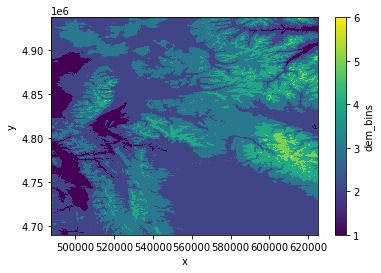

In [24]:
dembinned.plot()

**TODO:** 
- Figure out how to add labels to the groups
- See if other statistics (min, max, std) can be extracted at the same time as mean, as is possible with pandas groupby aggregations

In [25]:
swe_elevbin = zdsgeo.swe.groupby(dembinned).mean()
swe_elevbin

,Array,Chunk
Bytes,43.80 kB,16 B
Shape,"(1825, 6)","(4, 1)"
Count,14625 Tasks,2742 Chunks
Type,float32,numpy.ndarray


Propagate the swe variable attributes that were dropped; then apply `compute` on `swe_elevbin`, b/c it's a dask delayed array.

In [26]:
swe_elevbin.attrs = zdsgeo.swe.attrs

In [27]:
swe_elevbin = swe_elevbin.compute()

### Binning approach 2

`groupby_bins` may provide a more transparent and flexible solution. See http://xarray.pydata.org/en/stable/groupby.html. It also accepts labels for the bins, via the `labels` argument.

It is more transparent and simpler to define, but it appears to be slower than approach 1.

In [28]:
zdsgeo['dem_interp'] = dem_interp
zdsgeo['dem_interp'].attrs['long_name'] = 'Grid-interpolated DEM'

In [29]:
swe_elevbin_gbb = zdsgeo.groupby_bins('dem_interp', bins=bins).mean()
swe_elevbin_gbb

,Array,Chunk
Bytes,43.80 kB,16 B
Shape,"(6, 1825)","(1, 4)"
Count,18282 Tasks,2742 Chunks
Type,float32,numpy.ndarray


Propagate the swe variable attributes that were dropped; then apply `compute` on `swe_elevbin_gbb`, b/c it's a dask delayed array.

In [30]:
swe_elevbin_gbb.swe.attrs = zdsgeo.swe.attrs

In [31]:
swe_elevbin_gbb = swe_elevbin_gbb.compute()

## Explore the results

Time series plots by elevation bin

### Binning approach 1

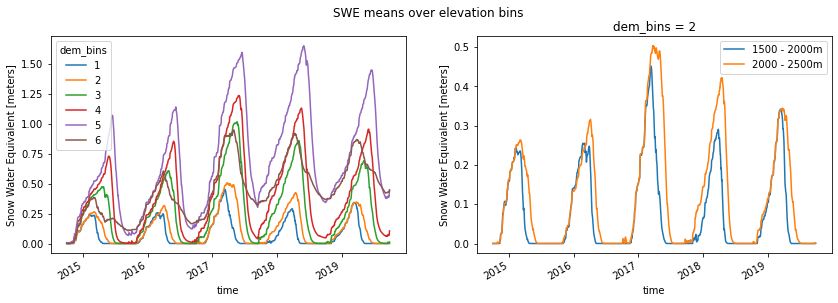

In [32]:
# Two different plotting methods. The first one gives control over legend labels, 
# but the second one is more compact and efficient

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))

swe_elevbin.sel(dem_bins=slice(0,len(bins1))).plot(ax=ax1, hue='dem_bins')

swe_elevbin.sel(dem_bins=1).plot(ax=ax2, label='1500 - 2000m')
swe_elevbin.sel(dem_bins=2).plot(ax=ax2, label='2000 - 2500m')
ax2.legend()

fig.suptitle("SWE means over elevation bins");

### Binning approach 2

**HMM, the 6th bin is corrupted the same way Approach 1 leads to a corrupted last bin (4500-5000) when 7 bins are used.**

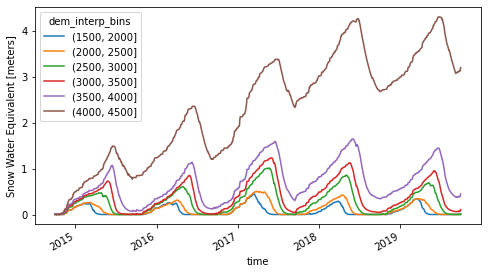

In [33]:
swe_elevbin_gbb.swe.isel(dem_interp_bins=slice(0,len(bins))).plot(hue='dem_interp_bins', figsize=(8,4));

### Area distribution by elevation bin

Here, as cell counts via groupby sum

In [34]:
elev_bin_df = dembinned.groupby(dembinned).sum().to_dataframe()

elev_bin_df = elev_bin_df.merge(bins_df, left_index=True, right_on='bin')
elev_bin_df.set_index('bin', drop=False, inplace=True)
elev_bin_df

,dem_bins,bin,elev_bin_start
bin,,,
1,230498,1,1500
2,3324184,2,2000
3,3426828,3,2500
4,1381048,4,3000
5,194180,5,3500
6,17208,6,4000


### Convert to DataFrame for use with Pandas, then merge with `bins_df`

But note that we lose the advantage of xarray variable attributes.

In [21]:
bins_df = pd.DataFrame(enumerate(bins1, 1), 
                       columns=['bin', 'elev_bin_start'])
bins_df

,bin,elev_bin_start
0,1,1500
1,2,2000
2,3,2500
3,4,3000
4,5,3500
5,6,4000


In [35]:
df = swe_elevbin.to_dataframe()
df.reset_index(inplace=True)

In [36]:
df.head()

,time,dem_bins,swe
0,2014-10-01,1,9.293264e-13
1,2014-10-01,2,9.060546e-05
2,2014-10-01,3,1.739738e-03
3,2014-10-01,4,5.388737e-03
4,2014-10-01,5,7.229493e-03


In [37]:
elev_bin_df['elev_bin_area_km2'] = elev_bin_df['dem_bins'] * (100/1000)**2

In [38]:
elev_bin_df

,dem_bins,bin,elev_bin_start,elev_bin_area_km2
bin,,,,
1,230498,1,1500,2304.98
2,3324184,2,2000,33241.84
3,3426828,3,2500,34268.28
4,1381048,4,3000,13810.48
5,194180,5,3500,1941.80
6,17208,6,4000,172.08


In [39]:
df = df.merge(elev_bin_df, left_on='dem_bins', right_index=True)
df.head()

,dem_bins,time,dem_bins_x,swe,dem_bins_y,bin,elev_bin_start,elev_bin_area_km2
0,1,2014-10-01,1,9.293264e-13,230498,1,1500,2304.98
6,1,2014-10-02,1,-8.826400e-16,230498,1,1500,2304.98
12,1,2014-10-03,1,2.093358e-09,230498,1,1500,2304.98
18,1,2014-10-04,1,-2.895469e-15,230498,1,1500,2304.98
24,1,2014-10-05,1,-3.617477e-15,230498,1,1500,2304.98


In [40]:
df.drop(columns=['dem_bins', 'dem_bins_x', 'dem_bins_y'], inplace=True)

In [41]:
df.head(10)

,time,swe,bin,elev_bin_start,elev_bin_area_km2
0,2014-10-01,9.293264e-13,1,1500,2304.98
6,2014-10-02,-8.826400e-16,1,1500,2304.98
12,2014-10-03,2.093358e-09,1,1500,2304.98
18,2014-10-04,-2.895469e-15,1,1500,2304.98
24,2014-10-05,-3.617477e-15,1,1500,2304.98
30,2014-10-06,-3.617477e-15,1,1500,2304.98
36,2014-10-07,-3.617477e-15,1,1500,2304.98
42,2014-10-08,-3.617477e-15,1,1500,2304.98
48,2014-10-09,-3.617477e-15,1,1500,2304.98
54,2014-10-10,-3.617477e-15,1,1500,2304.98
